# Data Gathering

Two independent data sources are used in the modeling process. The first is a dataset of vacant and abandoned buildings, defined by tax parcel area, in the form of an [ESRI shapefile](training_data/abandoned_and_vacant/) ([Data Source](https://data.indy.gov/datasets/abandoned-and-vacant-housing?geometry=-86.313%2C39.748%2C-85.983%2C39.794)). The second dataset is a [LiDAR imagery tile](training_data/las_files), in the file format .las ([Data Source](https://lidar.jinha.org/download.php?cname=marion&clon=-86.13305839196093&clat=39.779844384833936&years=2011,2016)). Certain steps are necessary to align the two datasets in the same spacial coordinate system.

The desired coordinate reference system (CRS) for both datasets is standard latitude longitude, whish is abbreviated by the EPSG code 4326. The vacant and abandoned buildings data is already in CRS 4326, however the LiDAR data is in an alternative CRS, represented by the code 102673. The LiDAR data is transformed to 4326 and finally aligned with the vacant and abandoned buildings data, as seen in the final image at the bottom of this notebook.

In [1]:
import geopandas as gp
import os
import numpy as np
from laspy.file import File
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pickle

## Coordinate Reference System constants

In [2]:
# CRS code for the input .las files
crs_input = 'ESRI:102673'

# Desired format
crs_lat_lon = 'EPSG:4326'

## Load geo-data on abandoned and vacant buildings

In [3]:
# Abandoned building data is stored here
base_path = './training_data/abandoned_and_vacant/'

# Abandoned building shapefile
gdf_abandoned = gp.read_file(base_path + 'Abandoned_And_Vacant_Housing.shp', crs=crs_lat_lon)

print(gdf_abandoned.shape)
gdf_abandoned.loc[:, ['ADDRESS', 'STATUS', 'geometry']].head()

(7216, 15)


,ADDRESS,STATUS,geometry
0,2365 ADAMS ST,Abandoned,"POLYGON ((-86.10858 39.80163, -86.10858 39.801..."
1,2755 N KEYSTONE AVE,Abandoned,"POLYGON ((-86.12098 39.80677, -86.12146 39.806..."
2,1929 HOUSTON ST,Abandoned,"POLYGON ((-86.10891 39.79337, -86.10891 39.793..."
3,40 EASTERN AVE,Abandoned,"POLYGON ((-86.11771 39.76975, -86.11816 39.769..."
4,1031 N TACOMA AVE,Abandoned,"POLYGON ((-86.11886 39.78222, -86.11951 39.782..."


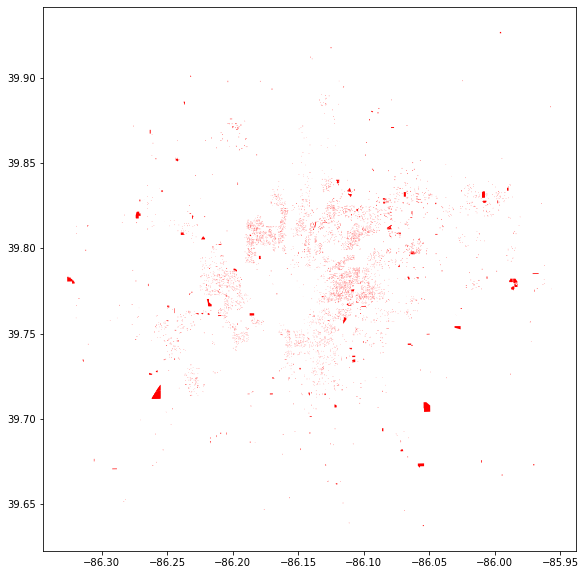

In [12]:
# Map the abandoned properties
f, ax = plt.subplots(figsize=(15,10))

gdf_abandoned.plot(ax=ax, color='red');

In [13]:
f.savefig('Abandoned_properties.png', bbox_inches='tight', quality=95)

<ipython-input-13-d08c4dd4f6c0>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Abandoned_properties.png', bbox_inches='tight', quality=95)


**Interpretation:** Each red shape represents an abandoned or vacant building. This area covers the entire Marion County region, with the corresponding longitude and latitude shown on the x and y axes. Below, we will focus on a subset of this region.

In [14]:
# Filter for abandoned buildings within the satellite image
x_abandoned = gdf_abandoned['geometry'].representative_point().x
y_abandoned = gdf_abandoned['geometry'].representative_point().y

# Bounds for LiDAR tile
x_min, x_max, y_min, y_max = -86.14016495696444, -86.12228581315563, 39.76377561875412, 39.777572323113745

x_valid = (x_abandoned > x_min) & (x_abandoned < x_max)
y_valid = (y_abandoned > y_min) & (y_abandoned < y_max)

gdf_abandoned_filtered = gdf_abandoned.loc[x_valid & y_valid, :].copy()

## Load the lidar data for Indianapolis, IN

In [15]:
def las_to_geodf(filename, crs=None):
    '''Convert an .las file to a Geopandas Geodataframe object.'''

    print('Trying file', filename, '\n')
    usft_to_meter = 0.30480060960121924
    base_path = './training_data/las_files/'

    #Read LAS file
    try:
        inFile = File(base_path + filename)
        print('inFile accepted.')
    except:
        print(filename, " failed.")
        return None

    #Import LAS into numpy array
    lidar_points = np.array((inFile.x*usft_to_meter,
                             inFile.y*usft_to_meter,
                             inFile.z*usft_to_meter,
                             inFile.intensity,
                             inFile.classification)).transpose()
    print('information accepted.')

    #Transform to geopandas GeoDataFrame
    lidar_geodf = gp.GeoDataFrame(lidar_points, geometry = gp.points_from_xy(inFile.x, inFile.y), crs=crs)
    lidar_geodf.rename(columns = {0:'x', 1:'y', 2:'z', 3:'intensity', 4:'classification'}, inplace=True)
    print('points accepted.')

    print(filename, " successful.\n")
    inFile.close()

    return lidar_geodf

In [16]:
# Lidar satellite data file
las_files = [f for f in os.listdir('./training_data/las_files/') if f[0]!='.']

las_file = las_files[0]
las_file

'MC_01951645.las'

In [18]:
# Load and convert to a geodataframe
gdf = las_to_geodf(las_file, crs=crs_input)
gdf

Trying file MC_01951645.las 

inFile accepted.
information accepted.
points accepted.
MC_01951645.las  successful.



,x,y,z,intensity,classification,geometry
0,60350.502413,502919.957328,227.442215,9216.0,1.0,POINT (197999.940 1649996.560)
1,60349.307595,502920.880874,227.518415,11264.0,1.0,POINT (197996.020 1649999.590)
2,60349.386843,502919.835408,227.454407,7424.0,1.0,POINT (197996.280 1649996.160)
3,60349.469139,502918.786894,227.426975,8704.0,2.0,POINT (197996.550 1649992.720)
4,60349.816612,502920.192024,238.101092,3584.0,1.0,POINT (197997.690 1649997.330)
...,...,...,...,...,...,...
11299799,60359.372111,502920.917450,235.046990,15104.0,1.0,POINT (198029.040 1649999.710)
11299800,60357.409195,502920.963170,227.539751,8448.0,1.0,POINT (198022.600 1649999.860)
11299801,60355.019558,502920.883922,239.369063,2560.0,1.0,POINT (198014.760 1649999.600)
11299802,60353.724155,502920.990602,240.423673,1536.0,1.0,POINT (198010.510 1649999.950)


In [19]:
# Convert to CRS 4326
gdf_4326 = gdf.loc[:, ['intensity', 'z', 'geometry']].to_crs(crs_lat_lon)
gdf_4326

KeyboardInterrupt: 

In [14]:
# Identify points that lie within an abandoned structure
points = gdf_abandoned_filtered[['geometry']]
shapes = gdf_4326[['geometry']]

pointInPolys = gp.sjoin(points, shapes, how='left')
pointInPolys.head()

,geometry,index_right
5,"POLYGON ((-86.12436 39.76983, -86.12436 39.769...",7949742
5,"POLYGON ((-86.12436 39.76983, -86.12436 39.769...",7945112
5,"POLYGON ((-86.12436 39.76983, -86.12436 39.769...",8285898
5,"POLYGON ((-86.12436 39.76983, -86.12436 39.769...",8290904
5,"POLYGON ((-86.12436 39.76983, -86.12436 39.769...",8270938


In [19]:
# Define target attribute
gdf_4326['abandoned_or_vacant'] = 0

yes_points = pointInPolys['index_right']
gdf_4326.loc[yes_points.values, 'abandoned_or_vacant'] = 1

# Verify the number of positives
print('Total number of pixels in for all abandoned buildings:', gdf_4326['abandoned_or_vacant'].sum(), '\n')
gdf_4326.head()

Total number of pixels in for all abandoned buildings: 352920 



,intensity,z,geometry,abandoned_or_vacant
0,9216.0,227.442215,POINT (-86.12949 39.77753),0
1,11264.0,227.518415,POINT (-86.12951 39.77754),0
2,7424.0,227.454407,POINT (-86.12951 39.77753),0
3,8704.0,227.426975,POINT (-86.12950 39.77752),0
4,3584.0,238.101092,POINT (-86.12950 39.77754),0


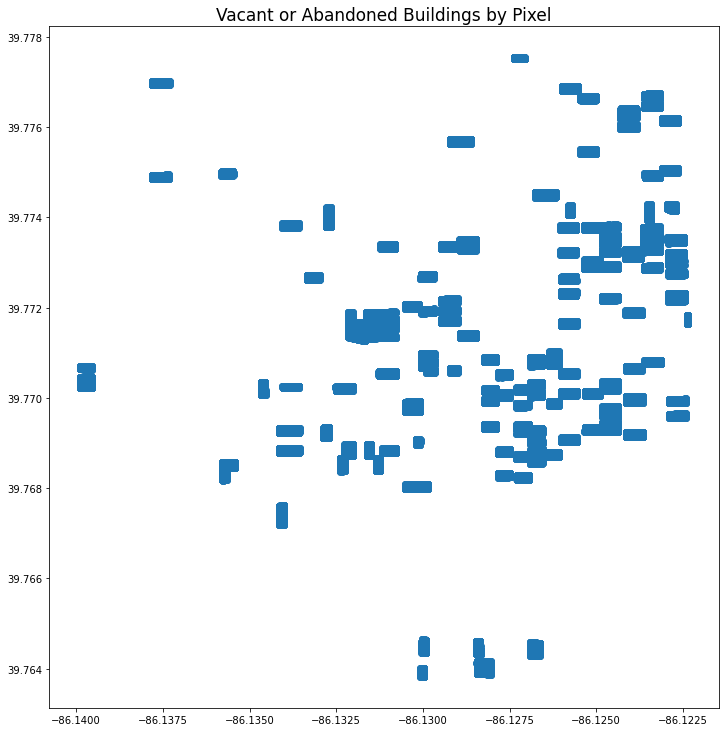

In [23]:
# Visually confirm the target values
f, ax = plt.subplots(figsize=(12,20))

gdf_4326.loc[yes_points.values, :].plot(ax=ax)

ax.set_title('Vacant or Abandoned Buildings by Pixel', size=17);

In [24]:
# Pickle the LiDAR GeoDataFrame
filename = 'las_file_geodf'
with open(filename, 'w+b') as outfile:
    pickle.dump(gdf_4326, outfile)

## EDA on LiDAR Data

Max: 382.47294894589794
Min: 36.40233680467362
Std: 5.8454407188369215


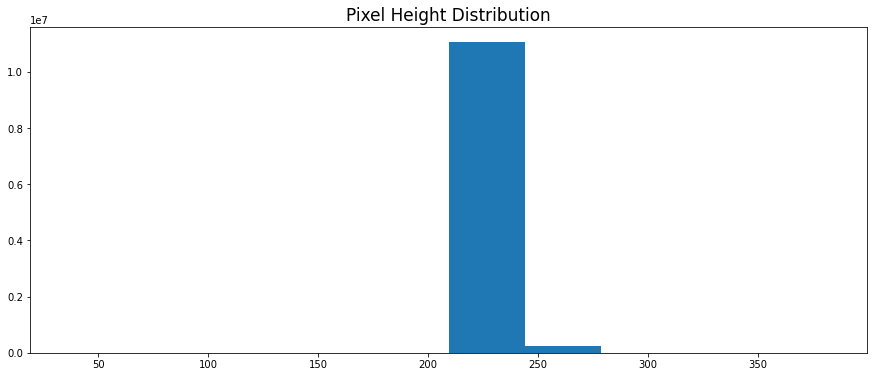

In [25]:
# Height Distribution
f, ax = plt.subplots(figsize=(15,6))

ax.hist(gdf_4326['z'])

ax.set_title('Pixel Height Distribution', size=17);

print('Max:', gdf_4326['z'].max())
print('Min:', gdf_4326['z'].min())
print('Std:', gdf_4326['z'].std())

**Interpretation:** The height variable has a narrow spread. This makes it impractical to use for the segmentation model.

In [26]:
# Investigate outliers
under_200 = sum(gdf_4326['z'] < 200)
print(under_200, 'Pixels under 200m')

over_300 = sum(gdf_4326['z'] > 300)
print(over_300, 'Pixels over 300m')

6 Pixels under 200m
136 Pixels over 300m


In [27]:
# Masks to eliminate distorting pixels
mask_valid_height = gdf_4326['z'] >= 200

Max: 65535.0
Min: 0.0
Std: 14737.071677424714


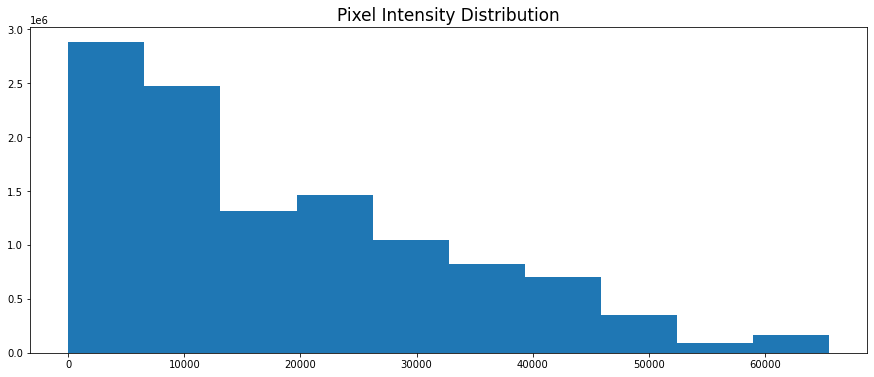

In [28]:
# Intensity Distribution
f, ax = plt.subplots(figsize=(15,6))

plt.hist(gdf_4326['intensity']);

ax.set_title('Pixel Intensity Distribution', size=17);

print('Max:', gdf['intensity'].max())
print('Min:', gdf['intensity'].min())
print('Std:', gdf['intensity'].std())

**Interpretation:** The intensity variable has far greater variation, as can be seen in the above plot as well as in the standard deviation. This makes intensity a suitable candidate for our model.

## Visualize

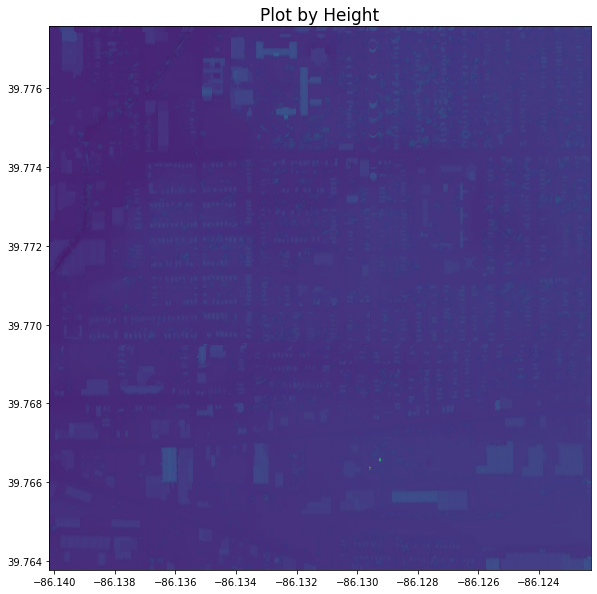

In [173]:
# Map the abandoned properties over the satelite image
# Using Height

# Boundaries for the LiDAR tile
x_min, x_max, y_min, y_max = -86.14016495696444, -86.12228581315563, 39.76377561875412, 39.777572323113745

# Plotting
f, ax = plt.subplots(figsize=(15,10))

gdf_4326.loc[mask_valid_height, :].plot('z', ax=ax)
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max)
ax.set_title('Plot by Height', size=17);

**Interpretation:** The height attribute needs additional processing to improve the resulting image's resolution. Intensity will be used instead as it produces a clearer image, as can be seen in the plot below.

In [20]:
# Load the LiDAR GeoDataFrame
pickled_file = open("las_file_geodf", "rb")
gdf_4326 = pickle.load(pickled_file)
gdf_4326

,intensity,z,geometry,abandoned_or_vacant
0,9216.0,227.442215,POINT (-86.12949 39.77753),0
1,11264.0,227.518415,POINT (-86.12951 39.77754),0
2,7424.0,227.454407,POINT (-86.12951 39.77753),0
3,8704.0,227.426975,POINT (-86.12950 39.77752),0
4,3584.0,238.101092,POINT (-86.12950 39.77754),0
...,...,...,...,...
11299799,15104.0,235.046990,POINT (-86.12939 39.77754),0
11299800,8448.0,227.539751,POINT (-86.12941 39.77754),0
11299801,2560.0,239.369063,POINT (-86.12944 39.77754),0
11299802,1536.0,240.423673,POINT (-86.12945 39.77754),0


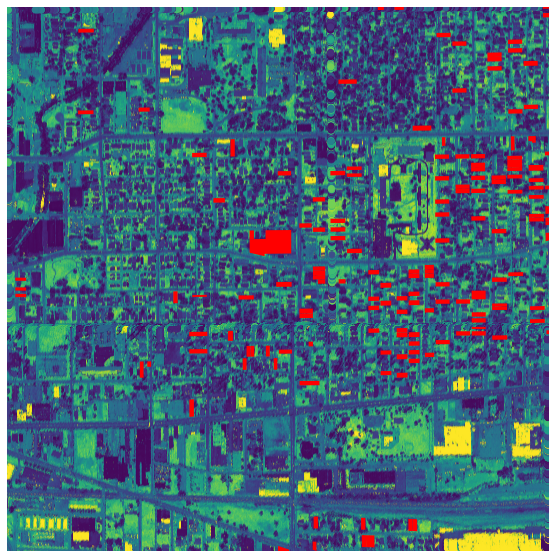

In [21]:
# Map the abandoned properties over the satelite image
# Using Intensity

# Boundaries for the LiDAR tile
x_min, x_max, y_min, y_max = -86.14016495696444, -86.12228581315563, 39.76377561875412, 39.777572323113745

# Plotting
f, ax = plt.subplots(figsize=(15,10))

gdf_4326.plot('intensity', ax=ax)
gdf_abandoned.plot(ax=ax, color='red')
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max)
plt.axis('off');

In [22]:
f.savefig('Labaled_tile.png', bbox_inches='tight', quality=95)

<ipython-input-22-3302fdb29193>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Labaled_tile.png', bbox_inches='tight', quality=95)


**Interpretaion:** The red blocks represent vacant buildings. Since the two datasets come from different sources, and particularly becasue they originated in different coordinate reference systems, we must check visually that they line up well. The above image is reassuring; there are no obvious signs of distortion such as red parcels overlying streets.

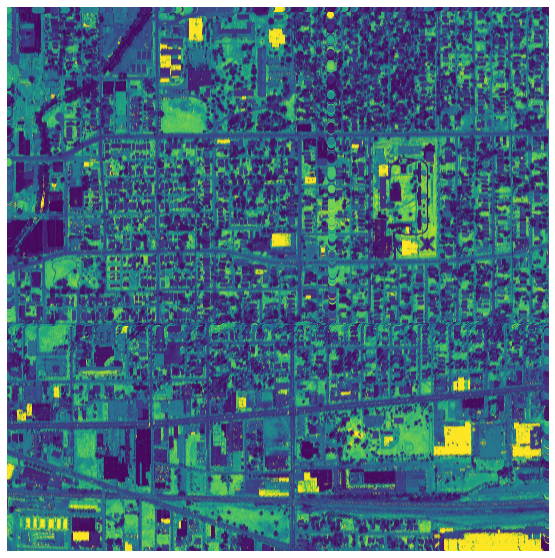

In [23]:
# Map the base satelite image
# Using Intensity

# Boundaries for the LiDAR tile
x_min, x_max, y_min, y_max = -86.14016495696444, -86.12228581315563, 39.76377561875412, 39.777572323113745

# Plotting
f, ax = plt.subplots(figsize=(15,10))

gdf_4326.plot('intensity', ax=ax)
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max)
plt.axis('off');

In [30]:
f.savefig('Base_tile.png', bbox_inches='tight', quality=95)

<ipython-input-30-39df1888ac8b>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Base_tile.png', bbox_inches='tight', quality=95)


---

In [31]:
# Lidar satellite validation data file
las_file_validation = las_files[1]

# Load and convert to a geodataframe
gdf_validation = las_to_geodf(las_file_validation, crs=crs_input)

# Convert to CRS 4326
gdf_4326_validation = gdf_validation.loc[:, ['intensity', 'z', 'geometry']].to_crs(crs_lat_lon)

Trying file MC_01951650.las 

inFile accepted.
information accepted.
points accepted.
MC_01951650.las  successful.



In [32]:
# Find the bounds of the tile
x = gdf_4326_validation['geometry'].x
y = gdf_4326_validation['geometry'].y

x_min, x_max, y_min, y_max = x.min(), x.max(), y.min(), y.max()
x_min, x_max, y_min, y_max

(-86.14025892728937, -86.12237639833283, 39.77750155912064, 39.791297435758466)

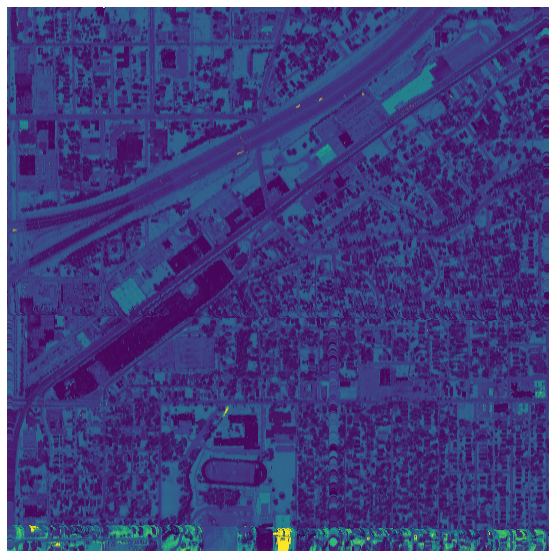

In [33]:
# Map the validation image
# Using Intensity

# Boundaries for the LiDAR tile

# Plotting
f, ax = plt.subplots(figsize=(15,10))

gdf_4326_validation.plot('intensity', ax=ax)
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max)
plt.axis('off');

In [34]:
f.savefig('Base_tile_validation.png', bbox_inches='tight', quality=95)

<ipython-input-34-b4af78613aa7>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Base_tile_validation.png', bbox_inches='tight', quality=95)


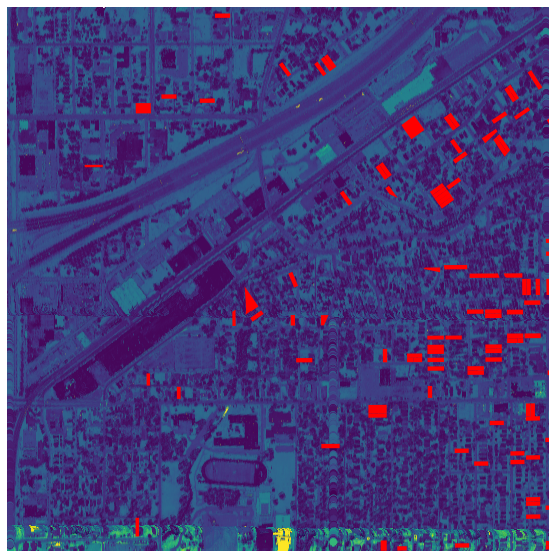

In [35]:
# Map the validation image
# Using Intensity

# Boundaries for the LiDAR tile

# Plotting
f, ax = plt.subplots(figsize=(15,10))

gdf_4326_validation.plot('intensity', ax=ax)
gdf_abandoned.plot(ax=ax, color='red')
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max)
plt.axis('off');

In [36]:
f.savefig('Labeled_tile_validation.png', bbox_inches='tight', quality=95)

<ipython-input-36-0bd31bc48fdb>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig('Labeled_tile_validation.png', bbox_inches='tight', quality=95)
